# **Siamese CNN Notebook for Cattle Nose Recognition**

### **Import libraries**

In [1]:
# Import libraries
import os
import random
import math
import time
import json
from pathlib import Path
from itertools import combinations
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torchvision.models as models

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, roc_curve, auc, classification_report,
    confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.manifold import TSNE

In [2]:
# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


### **Paths & quick dataset check**

In [5]:
# Paths - change these to match your environment
IMAGE_FOLDER = "/kaggle/input/titweng-cow-nose-dataset/train/images"   # cropped nose images or full images that are already cropped
OUTPUT_DIR = "/kaggle/working/siamese_output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# quick check
all_imgs = [f for f in os.listdir(IMAGE_FOLDER) if f.lower().endswith(('.jpg','.jpeg','.png'))]
print(f"Found {len(all_imgs)} images in {IMAGE_FOLDER}")
print("Sample filenames:", all_imgs[:10])


Found 2142 images in /kaggle/input/titweng-cow-nose-dataset/train/images
Sample filenames: ['065_001_jpg.rf.9f930c0fd819f23d89aefab636bd0829.jpg', '028_003_jpg.rf.4f36f85f24fb927d7f57610d946b9048.jpg', '003_006_jpg.rf.c388d8467f7cef4cdafb04ca8894c419.jpg', '061_010_jpg.rf.6c1e27b6080171ef73863979d2665d95.jpg', '033_008_jpg.rf.9dfb7d2429b519ebdcd23959acf872b3.jpg', '057_015_jpg.rf.ca9b5b64e2ece92cbdd0eee923189330.jpg', '055_008_jpg.rf.71ca052e985da3f2ff1de3b26c590e36.jpg', '033_007_jpg.rf.f9e5db7e2937096c07583674f4287daa.jpg', '001_018_jpg.rf.bccee8837aa9df4720ee59830b0e8ba3.jpg', '052_005_jpg.rf.79efa0f23d365be34ac3538ed6792724.jpg']


### **Build mapping: cow_id → list of images**

Usable cows (>=2 imgs): 69


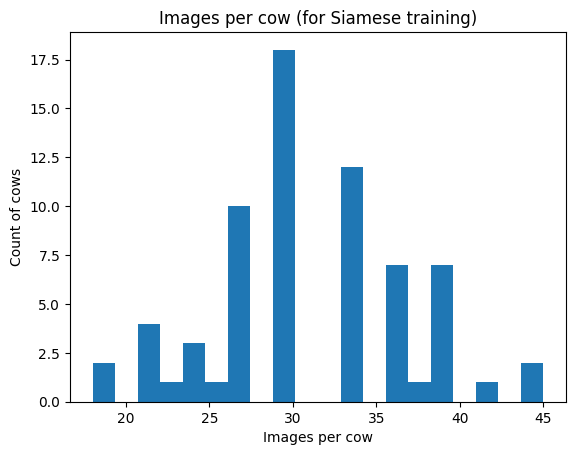

In [6]:
# Parse filenames to group by cow id
# Assumes filename format like "057_004.jpg" where "057" is cow id
cow_dict = defaultdict(list)
for fn in all_imgs:
    # extract cow id
    cow_id = fn.split("_")[0]
    cow_dict[cow_id].append(fn)

# Filter cows with >= 2 images (needed for positive pairs)
cow_dict = {k: v for k, v in cow_dict.items() if len(v) >= 2}
print(f"Usable cows (>=2 imgs): {len(cow_dict)}")
# Show distribution
counts = [len(v) for v in cow_dict.values()]
plt.hist(counts, bins=20)
plt.title("Images per cow (for Siamese training)")
plt.xlabel("Images per cow")
plt.ylabel("Count of cows")
plt.show()

### **Create pairs (positive & negative), with sampling to limit explosion**

In [7]:
# Generate pairs
def create_pairs(cow_dict, max_pos_per_cow=100, neg_ratio=1.0):
    """
    Create positive and negative pairs.
    - max_pos_per_cow: max number of positive pairs per cow (sample if too many)
    - neg_ratio: number of negative pairs per positive pair
    Returns: pairs [(img1, img2), ...], labels [1 or 0]
    """
    pairs = []
    labels = []
    cow_ids = list(cow_dict.keys())

    # positive pairs
    for cow in cow_ids:
        imgs = cow_dict[cow]
        pos_pairs = list(combinations(imgs, 2))
        if len(pos_pairs) > max_pos_per_cow:
            pos_pairs = random.sample(pos_pairs, max_pos_per_cow)
        for a, b in pos_pairs:
            pairs.append((a, b))
            labels.append(1)

    # negative pairs: sample random different-cow pairs
    n_pos = sum(labels)
    n_neg = int(n_pos * neg_ratio)
    for _ in range(n_neg):
        c1, c2 = random.sample(cow_ids, 2)
        img1 = random.choice(cow_dict[c1])
        img2 = random.choice(cow_dict[c2])
        pairs.append((img1, img2))
        labels.append(0)

    return pairs, labels

pairs, labels = create_pairs(cow_dict, max_pos_per_cow=100, neg_ratio=1.0)
print("Total pairs:", len(pairs), "Pos:", sum(labels), "Neg:", len(labels)-sum(labels))


Total pairs: 13800 Pos: 6900 Neg: 6900


### **Train / Val split (pair-level)**

In [8]:
# Split into train/val
pairs_train, pairs_val, y_train, y_val = train_test_split(
    pairs, labels, test_size=0.2, random_state=SEED, stratify=labels
)

print("Train pairs:", len(pairs_train), "Val pairs:", len(pairs_val))

Train pairs: 11040 Val pairs: 2760


### **Dataset class & transforms**

In [9]:
# Dataset class
class SiameseDataset(Dataset):
    def __init__(self, image_folder, pairs, labels, transform=None):
        self.image_folder = image_folder
        self.pairs = pairs
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        a_name, b_name = self.pairs[idx]
        a_path = os.path.join(self.image_folder, a_name)
        b_path = os.path.join(self.image_folder, b_name)

        a_img = Image.open(a_path).convert("RGB")
        b_img = Image.open(b_path).convert("RGB")

        if self.transform:
            a_img = self.transform(a_img)
            b_img = self.transform(b_img)

        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return a_img, b_img, label

# Transforms (augmentations)
transform_train = T.Compose([
    T.Resize((128, 128)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(10),
    T.ColorJitter(brightness=0.2, contrast=0.2),
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

transform_val = T.Compose([
    T.Resize((128,128)),
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

train_dataset = SiameseDataset(IMAGE_FOLDER, pairs_train, y_train, transform=transform_train)
val_dataset = SiameseDataset(IMAGE_FOLDER, pairs_val, y_val, transform=transform_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)


### **Model architecture — Siamese with ResNet18 backbone**

In [11]:
# Siamese model: ResNet18 backbone (pretrained) + embedding head
class SiameseNetwork(nn.Module):
    def __init__(self, embedding_dim=256, pretrained=True, freeze_backbone=False):
        super().__init__()
        # Load ResNet18 backbone
        backbone = models.resnet18(pretrained=pretrained)
        # remove final fc
        modules = list(backbone.children())[:-1]  # remove the last fc
        self.backbone = nn.Sequential(*modules)  # outputs [B,512,1,1]
        if freeze_backbone:
            for p in self.backbone.parameters():
                p.requires_grad = False

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, embedding_dim)
        )

    def forward_one(self, x):
        x = self.backbone(x)           # [B,512,1,1]
        x = self.fc(x)                 # [B, embedding_dim]
        x = F.normalize(x, p=2, dim=1) # normalize embedding (important)
        return x

    def forward(self, x1, x2):
        return self.forward_one(x1), self.forward_one(x2)

# Instantiate model
model = SiameseNetwork(embedding_dim=256, pretrained=True, freeze_backbone=False).to(device)
print(model)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 195MB/s]


SiameseNetwork(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_sta

### **Loss function — Contrastive Loss**

In [12]:
# Contrastive loss
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super().__init__()
        self.margin = margin

    def forward(self, out1, out2, label):
        """
        label: 1 -> same, 0 -> different
        use pairwise distance (euclidean)
        """
        euclidean_distance = F.pairwise_distance(out1, out2)
        loss_pos = label * torch.pow(euclidean_distance, 2)                  # positive pairs
        loss_neg = (1 - label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)
        loss = torch.mean(loss_pos + loss_neg)
        return loss

criterion = ContrastiveLoss(margin=1.0)

### **Training loop with validation & checkpointing**

In [13]:
# Training loop
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
num_epochs = 20
best_val_auc = 0.0
history = {"train_loss": [], "val_loss": [], "val_auc": []}

for epoch in range(1, num_epochs+1):
    model.train()
    running_loss = 0.0
    start = time.time()
    for a, b, lbl in train_loader:
        a = a.to(device); b = b.to(device); lbl = lbl.to(device)
        optimizer.zero_grad()
        out1, out2 = model(a, b)
        loss = criterion(out1, out2, lbl)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * a.size(0)

    avg_train_loss = running_loss / len(train_loader.dataset)
    history["train_loss"].append(avg_train_loss)

    # validation
    model.eval()
    val_loss = 0.0
    all_labels = []
    all_scores = []
    with torch.no_grad():
        for a, b, lbl in val_loader:
            a = a.to(device); b = b.to(device); lbl = lbl.to(device)
            out1, out2 = model(a, b)
            loss = criterion(out1, out2, lbl)
            val_loss += loss.item() * a.size(0)
            # distance as score (smaller -> same)
            dist = F.pairwise_distance(out1, out2).cpu().numpy()
            all_scores.extend(dist.tolist())
            all_labels.extend(lbl.cpu().numpy().tolist())

    avg_val_loss = val_loss / len(val_loader.dataset)
    # compute ROC AUC (we want higher score for negative, so invert distances)
    fpr, tpr, thresholds = roc_curve(all_labels, -np.array(all_scores))  # invert so same=1-large
    val_auc = auc(fpr, tpr)
    history["val_loss"].append(avg_val_loss)
    history["val_auc"].append(val_auc)

    # scheduler step
    scheduler.step()

    elapsed = time.time() - start
    print(f"Epoch {epoch}/{num_epochs} — train_loss: {avg_train_loss:.4f} val_loss: {avg_val_loss:.4f} val_auc: {val_auc:.4f} time: {elapsed:.1f}s")

    # checkpoint best
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        torch.save({
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "epoch": epoch,
            "val_auc": val_auc
        }, os.path.join(OUTPUT_DIR, "siamese_best_checkpoint.pth"))
        print("  Saved best checkpoint.")


Epoch 1/20 — train_loss: 0.1127 val_loss: 0.0306 val_auc: 0.9973 time: 93.1s
  Saved best checkpoint.
Epoch 2/20 — train_loss: 0.0484 val_loss: 0.0190 val_auc: 0.9989 time: 86.1s
  Saved best checkpoint.
Epoch 3/20 — train_loss: 0.0330 val_loss: 0.0164 val_auc: 0.9989 time: 84.1s
  Saved best checkpoint.
Epoch 4/20 — train_loss: 0.0246 val_loss: 0.0144 val_auc: 0.9993 time: 84.0s
  Saved best checkpoint.
Epoch 5/20 — train_loss: 0.0196 val_loss: 0.0128 val_auc: 0.9997 time: 84.5s
  Saved best checkpoint.
Epoch 6/20 — train_loss: 0.0173 val_loss: 0.0119 val_auc: 0.9993 time: 84.6s
Epoch 7/20 — train_loss: 0.0142 val_loss: 0.0109 val_auc: 0.9996 time: 87.7s
Epoch 8/20 — train_loss: 0.0123 val_loss: 0.0103 val_auc: 0.9992 time: 86.0s
Epoch 9/20 — train_loss: 0.0108 val_loss: 0.0095 val_auc: 0.9999 time: 86.5s
  Saved best checkpoint.
Epoch 10/20 — train_loss: 0.0096 val_loss: 0.0092 val_auc: 0.9994 time: 87.8s
Epoch 11/20 — train_loss: 0.0084 val_loss: 0.0084 val_auc: 0.9993 time: 84.7s
E

### **Plot learning curves**

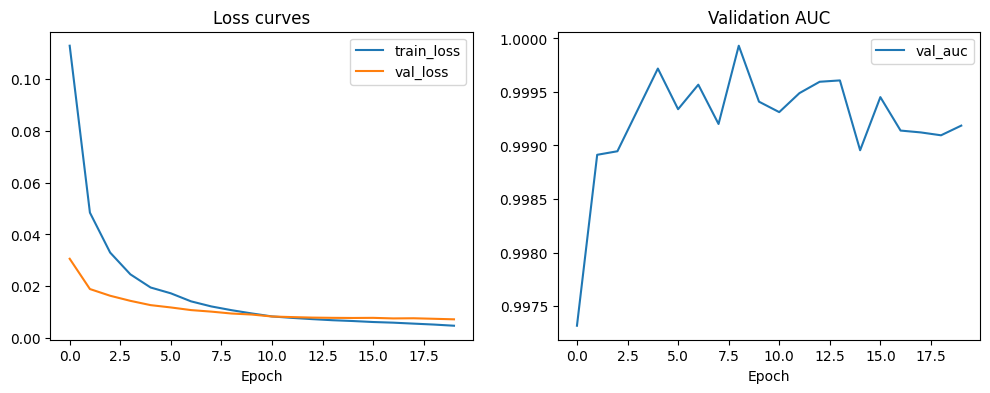

In [14]:
# Plot loss and AUC
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history["train_loss"], label="train_loss")
plt.plot(history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.legend()
plt.title("Loss curves")

plt.subplot(1,2,2)
plt.plot(history["val_auc"], label="val_auc")
plt.xlabel("Epoch")
plt.legend()
plt.title("Validation AUC")
plt.show()

### **Pick threshold from ROC, evaluate on validation (accuracy, cm, report)**

AUC: 0.9992, best_thresh (on inverted scores): -0.0646, best_f1: 0.9971
Classification report:
              precision    recall  f1-score   support

        diff       1.00      0.99      1.00      1380
        same       0.99      1.00      1.00      1380

    accuracy                           1.00      2760
   macro avg       1.00      1.00      1.00      2760
weighted avg       1.00      1.00      1.00      2760



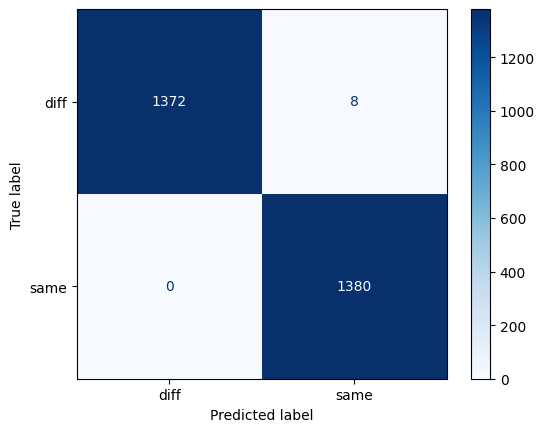

In [15]:
# Compute best threshold from validation ROC by maximizing F1
from sklearn.metrics import f1_score

# recompute all_scores/all_labels for final validation pass (we saved them above)

scores = np.array(all_scores)  # distances
labels_arr = np.array(all_labels)

# invert distances for ROC (higher => same)
y_score = -scores
fpr, tpr, thresholds = roc_curve(labels_arr, y_score)
roc_auc = auc(fpr, tpr)
# choose threshold maximizing F1
best_thresh = 0.0
best_f1 = -1
for thresh in thresholds:
    preds = (y_score >= thresh).astype(int)
    f1 = f1_score(labels_arr, preds)
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = thresh

print(f"AUC: {roc_auc:.4f}, best_thresh (on inverted scores): {best_thresh:.4f}, best_f1: {best_f1:.4f}")

# Evaluate final metrics
preds_final = (y_score >= best_thresh).astype(int)
print("Classification report:")
print(classification_report(labels_arr, preds_final, target_names=["diff","same"]))
cm = confusion_matrix(labels_arr, preds_final, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["diff","same"])
disp.plot(cmap="Blues")
plt.show()

### **Save final model & save averaged embeddings (db) for all registered cows**

In [16]:
# Save final model (state dict)
final_model_path = os.path.join(OUTPUT_DIR, "siamese_model_final.pth")
torch.save(model.state_dict(), final_model_path)
print("Saved siamese model to", final_model_path)

# Create embeddings database: compute representative embedding per cow (mean of embeddings)
model.eval()
cow_embeddings = {}  # cow_id -> list of embeddings
with torch.no_grad():
    for cow_id, imgs in cow_dict.items():
        emb_list = []
        for fn in imgs:
            img_path = os.path.join(IMAGE_FOLDER, fn)
            img = Image.open(img_path).convert("RGB")
            img_t = transform_val(img).unsqueeze(0).to(device)
            emb = model.forward_one(img_t)         # [1, embed_dim]
            emb_list.append(emb.cpu().numpy().flatten())
        if emb_list:
            cow_embeddings[cow_id] = np.mean(np.vstack(emb_list), axis=0)

# save embeddings to npz or json (npz recommended)
np.savez(os.path.join(OUTPUT_DIR, "cow_embeddings.npz"), **cow_embeddings)
print("Saved cow embeddings (representatives) to", os.path.join(OUTPUT_DIR, "cow_embeddings.npz"))

# also save metadata mapping if needed
with open(os.path.join(OUTPUT_DIR, "cow_list.json"), "w") as f:
    json.dump(list(cow_embeddings.keys()), f)

Saved siamese model to /kaggle/working/siamese_output/siamese_model_final.pth
Saved cow embeddings (representatives) to /kaggle/working/siamese_output/cow_embeddings.npz


### **Quick test: verify a random pair using the trained model & threshold**

In [17]:
# Quick test function
from scipy.spatial.distance import cosine

def get_embedding_for_image(image_path, model, transform, device):
    img = Image.open(image_path).convert("RGB")
    img_t = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        emb = model.forward_one(img_t).cpu().numpy().flatten()
    return emb

# pick a random positive and negative pair
pos_pair = pairs_train[0]   # should be positive only if label 1, otherwise search
# find a positive pair for testing
for p,l in zip(pairs_train, y_train):
    if l==1:
        a,b = p; break
a_emb = get_embedding_for_image(os.path.join(IMAGE_FOLDER,a), model, transform_val, device)
b_emb = get_embedding_for_image(os.path.join(IMAGE_FOLDER,b), model, transform_val, device)
dist = np.linalg.norm(a_emb - b_emb)
print("Positive pair distance:", dist)

# random negative
for p,l in zip(pairs_train, y_train):
    if l==0:
        a2,b2 = p; break
a2_emb = get_embedding_for_image(os.path.join(IMAGE_FOLDER,a2), model, transform_val, device)
b2_emb = get_embedding_for_image(os.path.join(IMAGE_FOLDER,b2), model, transform_val, device)
dist2 = np.linalg.norm(a2_emb - b2_emb)
print("Negative pair distance:", dist2)

print("Threshold (distance inverted used earlier). In our ROC we used inverted distance; apply consistency when comparing.")

Positive pair distance: 0.0042513018
Negative pair distance: 1.854885
Threshold (distance inverted used earlier). In our ROC we used inverted distance; apply consistency when comparing.


### **Visualize embeddings with t-SNE**

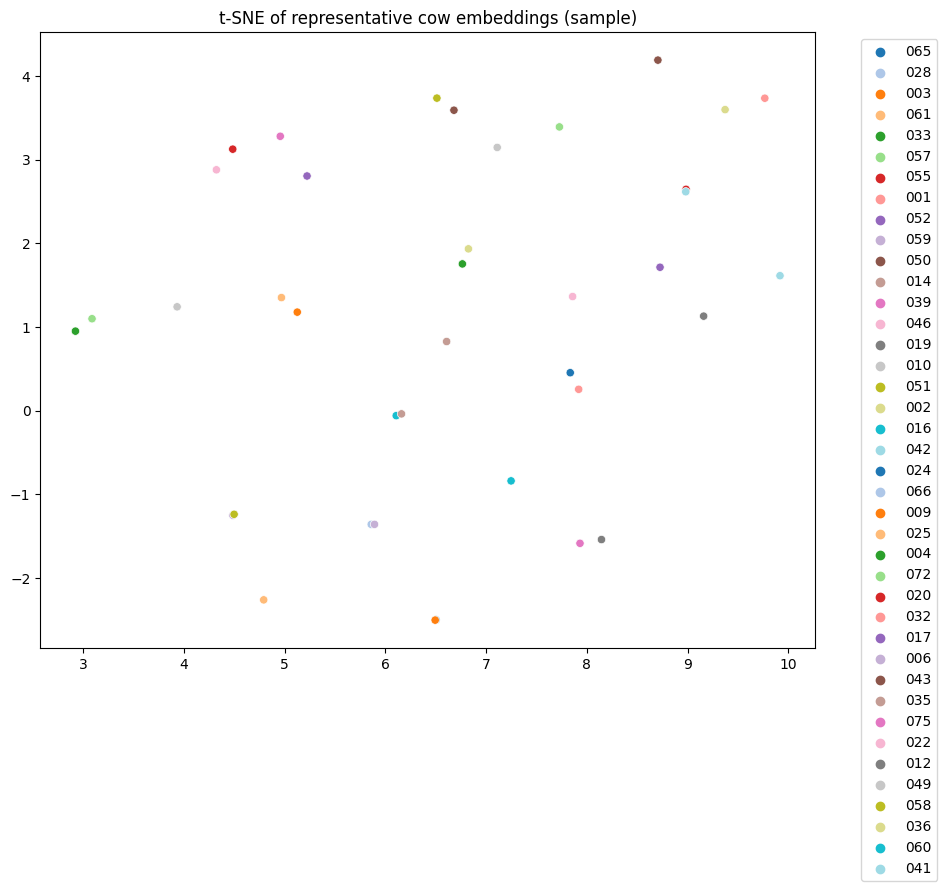

In [18]:
# t-SNE visualize representative embeddings for N cows
cow_sample = list(cow_embeddings.keys())[:40]  # up to 40 cows
emb_matrix = np.vstack([cow_embeddings[c] for c in cow_sample])
tsne = TSNE(n_components=2, random_state=SEED, perplexity=20, n_iter=1000)
emb_2d = tsne.fit_transform(emb_matrix)

plt.figure(figsize=(10,8))
sns.scatterplot(x=emb_2d[:,0], y=emb_2d[:,1], hue=cow_sample, palette="tab20")
plt.title("t-SNE of representative cow embeddings (sample)")
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.show()